# SINVAD Experiments - Research Question 3 (Indecisiveness)

This notebook provides outlines on experiments performed for RQ3 (Section 5.4 of paper). It contains code that generates results for Figure 6 (from RQ1), Figure 13, and Table 3 in the paper. Here we only present the code for MNIST; the principle is similar for FashionMNIST.

## Step 0. Preparation

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm_n
plt.style.use('seaborn')

from sa.model import MnistClassifier
from vae.model import VAE

In [2]:
img_size = 28*28*1
torch.no_grad() # since nothing is trained here

In [3]:
vae = VAE(img_size = 28*28, h_dim = 1600, z_dim = 400)
vae.load_state_dict(torch.load('./vae/models/MNIST_EnD.pth'))
vae.cuda()

classifier = MnistClassifier(img_size = img_size)
classifier.load_state_dict(torch.load('./sa/models/MNIST_conv_classifier.pth'))
classifier.cuda()
print("models loaded")

models loaded


In [4]:
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=False)
test_data_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)
print("Data loader ready")

Data loader ready


## Step 1. Calculate prediction variance in different datasets

In [5]:
def pred_diff(img, classifier, rep_num = 10):
    preds = []
    prob_f = nn.Softmax(dim=1)
    for r_idx in range(rep_num):
        pred = prob_f(classifier(img))
        preds.append(pred)
    preds = torch.cat(preds, dim=0)
    variances = torch.var(preds, dim=0, unbiased=False)
    return variances

In [6]:
norm_accum = 0.
for i, (x, x_class) in tqdm_n(enumerate(test_data_loader)):
    samp_img = x[0:1].cuda()
    diff = pred_diff(samp_img, classifier)
    norm_accum += diff.sum().item()
print('Dataset test image variation:', norm_accum/10000)


Dataset test image variation: 0.004852022237710898


In [7]:
bound_imgs = np.load('./data/bound_imgs_MNIST.npy')

In [8]:
batch_imgs = bound_imgs.reshape((1, 10000, 28, 28))
batch_imgs = batch_imgs.transpose((1, 0, 2, 3))
tensor_imgs = torch.Tensor(batch_imgs).cuda()

In [9]:
bound_accum = 0.
for img_idx in tqdm_n(range(10000)):
    tensor_img = tensor_imgs[img_idx:img_idx+1]
    diff = pred_diff(tensor_img, classifier)
    bound_accum += diff.sum().item()
print('SINVAD-generated image variation:', bound_accum/10000)


SINVAD-generated image variation: 0.19656181446552157


## Step 2. PCA visaulization of boundary images

In [10]:
from sklearn.decomposition import PCA
import seaborn as sns

In [11]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
train_data_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)

In [12]:
# get vectors and perform PCA
lyr_num = 7
all_ats = torch.zeros(0, 512)
for i, (x, x_class) in enumerate(train_data_loader):
    x = x.cuda()
    ats = classifier.at_by_layer(x, layer_idx=lyr_num).detach()
    all_ats = torch.cat([all_ats, ats.cpu()], dim=0)
all_ats = all_ats.transpose(0, 1).numpy()
rem_cols = np.mean(all_ats, axis=1) == 0
ref_all_ats = all_ats[~rem_cols]

pca = PCA(n_components = 2)
pca.fit(ref_all_ats.transpose())

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

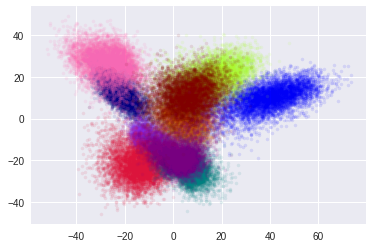

Legend: [(0, 'Navy'), (1, 'BlueViolet'), (2, 'Chocolate'), (3, 'Blue'), (4, 'Crimson'), (5, 'GreenYellow'), (6, 'HotPink'), (7, 'Teal'), (8, 'Maroon'), (9, 'Purple')]


In [13]:
digit_ats = [torch.zeros(0, 512) for _ in range(10)]
for i, (x, x_class) in enumerate(train_data_loader):
    x = x.cuda()
    ats = classifier.at_by_layer(x, layer_idx=lyr_num).detach()
    for d_idx in range(10):
        digit_at = ats[x_class == d_idx]
        digit_ats[d_idx] = torch.cat([digit_ats[d_idx], digit_at.cpu()], dim=0)

for d_idx in range(10):
    digit_ats[d_idx] = digit_ats[d_idx].numpy()[:, ~rem_cols]

# scatterplot of distribution with color (color from 0 to 9)
colors = ['Navy', 'BlueViolet', 'Chocolate', 'Blue', 'Crimson', 
          'GreenYellow', 'HotPink', 'Teal', 'Maroon', 'Purple']
for d_idx, c_name in enumerate(colors):
    d_data = pca.transform(digit_ats[d_idx])
    x, y = d_data[:, 0], d_data[:, 1]
    plt.plot(x, y, ".", color=c_name, alpha=0.1)
plt.show()
print('Legend:', list(enumerate(colors)))

In [14]:
# load boundary images
import data_loader
from data_loader import LabeledBoundaryData

import importlib
importlib.reload(data_loader)

bound_dataset = LabeledBoundaryData(root='./data',
                                    train=False,
                                    transform=transforms.ToTensor(),
                                    download=False, 
                                    bound_data='./data/bound_imgs_MNIST.npy',
                                    bound_label='./data/bound_imgs_MNIST_labels.npy')
bound_data_loader = torch.utils.data.DataLoader(dataset=bound_dataset,
                                               batch_size=1,
                                               shuffle=True)

In [15]:
class_pair = (3, 5)

In [16]:
class_bound_imgs = []
for i, (x, x_class) in enumerate(bound_data_loader):
    if (x_class == 10*class_pair[0]+class_pair[1] or 
        x_class == 10*class_pair[1]+class_pair[0]):
        class_bound_imgs.append(x)
        if len(class_bound_imgs) > 100:
            break # prettify
print(f'images of class {class_pair}: {len(class_bound_imgs)}')

images of class (3, 5): 101


In [17]:
D1 = pca.transform(digit_ats[class_pair[0]])
D2 = pca.transform(digit_ats[class_pair[1]])

(-21.553711891174316, 78.0289888381958, -21.84699058532715, 43.620473861694336)

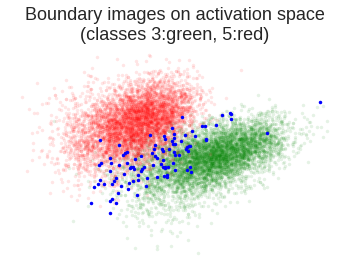

In [18]:
# Recall that below plot is not of z, but PCA of AT. 
movement_tracker = np.zeros((0, digit_ats[0].shape[1]))
for c_img in class_bound_imgs:
    recomb_img = c_img.cuda()
    recomb_at = classifier.at_by_layer(recomb_img, layer_idx=lyr_num)
    recomb_at = recomb_at.detach().cpu().numpy()
    recomb_at = recomb_at[:, ~rem_cols]
    movement_tracker = np.vstack([movement_tracker, recomb_at])
pca_movement = pca.transform(movement_tracker)
plt.plot(D1[:, 0], D1[:, 1], "g.", alpha=0.1, label="%d (green)" % class_pair[0])
plt.plot(D2[:, 0], D2[:, 1], "r.", alpha=0.1, label="%d (red)" % class_pair[1])
plt.plot(pca_movement[:, 0], pca_movement[:, 1], 'b.', label="SINVAD\nimages (blue)")
# plt.legend(loc="upper left", fontsize=15)
plt.title(f"Boundary images on activation space\n(classes {class_pair[0]}:green, {class_pair[1]}:red)", fontsize=18)
plt.axis('off')

## Appenndix. Visualization of SINVAD-generated images (Fig. 6)

(-0.5, 251.5, 111.5, -0.5)

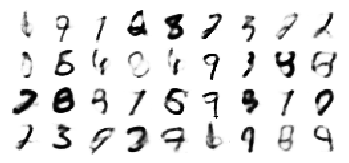

In [19]:
imgs = np.load('./data/bound_imgs_MNIST.npy')
imgs = imgs.reshape((-1, 1, 28, 28))

h_size = 9
v_size = 4
showcase = np.zeros((28*v_size, 28*h_size))
for i in range(v_size):
    for j in range(h_size):
        showcase[28*i:28*(i+1), 28*j:28*(j+1)] = imgs[h_size*i+j]
plt.imshow(showcase)
plt.axis('off')